# Segmentation of Credit Card Customers

A credit card company wants to segment its customers inorder to make targeted marketing strategies. Inorder to do that, a sample usage behaviour of 9000 active credit card users during the last 6 months is taken to create the segments. 18 behavioural variables are ascertained. 

### Segmentation

Segmentation is the type of analysis where the given data is divided into k groups. It is a type of analysis where there is no target variable that the model trains on, but looks at the given data and identifies patterns in it to assign all the given data into various groups (a.k.a. Segments). These segments are then used to see common behaviour accross various measures to identify behavioural charechteristics of these segments. This is the reason why segmentation is a very important analysis for marketing.

### Conducting the analysis

Importing Libraries

In [28]:
library(data.table)
library(dplyr)
library(psych)
library(GPArotation)
library(fastDummies)
library(cluster)
library(ggplot2)
library(tables)
options(scipen = 999)

Importing the data

In [29]:
cc <- fread("CC GENERAL.csv")

In [30]:
str(cc)

Classes 'data.table' and 'data.frame':	8950 obs. of  18 variables:
 $ CUST_ID                         : chr  "C10001" "C10002" "C10003" "C10004" ...
 $ BALANCE                         : num  40.9 3202.5 2495.1 1666.7 817.7 ...
 $ BALANCE_FREQUENCY               : num  0.818 0.909 1 0.636 1 ...
 $ PURCHASES                       : num  95.4 0 773.2 1499 16 ...
 $ ONEOFF_PURCHASES                : num  0 0 773 1499 16 ...
 $ INSTALLMENTS_PURCHASES          : num  95.4 0 0 0 0 ...
 $ CASH_ADVANCE                    : num  0 6443 0 206 0 ...
 $ PURCHASES_FREQUENCY             : num  0.1667 0 1 0.0833 0.0833 ...
 $ ONEOFF_PURCHASES_FREQUENCY      : num  0 0 1 0.0833 0.0833 ...
 $ PURCHASES_INSTALLMENTS_FREQUENCY: num  0.0833 0 0 0 0 ...
 $ CASH_ADVANCE_FREQUENCY          : num  0 0.25 0 0.0833 0 ...
 $ CASH_ADVANCE_TRX                : int  0 4 0 1 0 0 0 0 0 0 ...
 $ PURCHASES_TRX                   : int  2 0 12 1 1 8 64 12 5 3 ...
 $ CREDIT_LIMIT                    : num  1000 7000 7500 75

Now we create a few new measures

In [31]:
cc$AVG_PURCHASES <- cc$PURCHASES/cc$TENURE # Average Purchases made during the tennure
cc$AVG_CASH_ADVANCE <- cc$CASH_ADVANCE/cc$TENURE #Average cash advance over tennure
cc$PURCHASE_TYPE <- ifelse(cc$ONEOFF_PURCHASES == 0 & cc$INSTALLMENTS_PURCHASES > 0,"Installments",
                           ifelse(cc$ONEOFF_PURCHASES > 0 & cc$INSTALLMENTS_PURCHASES == 0,"One-off","Cash Advance")) # Type of purchase
cc$LIMIT_USAGE <- cc$BALANCE/cc$CREDIT_LIMIT # Limit usage ratio
cc$PAYM_MIN_PAYM <- cc$PAYMENTS/cc$MINIMUM_PAYMENTS # total payments made against minimum payments required to be made
cc$AVG_PER_TRX_PUR <- cc$PURCHASES/cc$PURCHASES_TRX #Average purchase value per transaction
cc$AVG_PER_TRX_CA <- cc$CASH_ADVANCE/cc$CASH_ADVANCE_TRX #Average cash advance value per cash advance transaction

We will now examine all the variables in detail

In [32]:
# Custom Functions
about <- function(x){
  
  n = length(x)
  nmiss = sum(is.na(x))
  nmiss_pct = (mean(is.na(x)))*100
  sum = sum(x, na.rm=T)
  mean = mean(x, na.rm=T)
  median = quantile(x, p=0.5, na.rm=T)
  std = sd(x, na.rm=T)
  var = var(x, na.rm=T)
  range = max(x, na.rm=T)-min(x, na.rm=T)
  pctl = quantile(x, p=c(0, 0.01, 0.05,0.1,0.25,0.5, 0.75,0.9,0.95,0.99,1), na.rm=T)
  return(c(N=n, Nmiss =nmiss, Nmiss_pct = nmiss_pct, sum=sum, avg=mean, meidan=median, std=std, var=var, range=range, pctl=pctl))
  
}

about_rest <- function(x){
  
  n = length(x)
  nmiss = sum(is.na(x))
  nmiss_pct = (mean(is.na(x)))*100
  return(c(N=n, Nmiss =nmiss, Nmiss_pct = nmiss_pct))
  
}

Numeric Variables

In [33]:
nums <- names(cc)[sapply(cc, is.numeric)]
(abt_nums <- as.data.frame(t(sapply(cc[,..nums],about))))

,N,Nmiss,Nmiss_pct,sum,avg,meidan.50%,std,var,range,pctl.0%,pctl.1%,pctl.5%,pctl.10%,pctl.25%,pctl.50%,pctl.75%,pctl.90%,pctl.95%,pctl.99%,pctl.100%
BALANCE,8950,0,0.00000000,14002049.708,1564.4748277,873.3852310,2081.5318795,4332774.96519394,19043.13856,0.000000000,0.06510059000,8.814518350,23.575528800,128.28191550,873.3852310,2054.1400355,4338.5636566,5909.1118078,9338.804814,19043.13856
BALANCE_FREQUENCY,8950,0,0.00000000,7851.573,0.8772707,1.0000000,0.2369040,0.05612351,1.00000,0.000000000,0.09090900000,0.272727000,0.454545000,0.88888900,1.0000000,1.0000000,1.0000000,1.0000000,1.000000,1.00000
PURCHASES,8950,0,0.00000000,8978683.260,1003.2048335,361.2800000,2136.6347819,4565208.19110901,49039.57000,0.000000000,0.00000000000,0.000000000,0.000000000,39.63500000,361.2800000,1110.1300000,2542.6240000,3998.6195000,8977.290000,49039.57000
ONEOFF_PURCHASES,8950,0,0.00000000,5302314.470,592.4373709,38.0000000,1659.8879174,2755227.89845603,40761.25000,0.000000000,0.00000000000,0.000000000,0.000000000,0.00000000,38.0000000,577.4050000,1600.0990000,2671.0940000,6689.898200,40761.25000
INSTALLMENTS_PURCHASES,8950,0,0.00000000,3679055.420,411.0676447,89.0000000,904.3381152,817827.42655896,22500.00000,0.000000000,0.00000000000,0.000000000,0.000000000,0.00000000,89.0000000,468.6375000,1140.0700000,1750.0875000,3886.240500,22500.00000
CASH_ADVANCE,8950,0,0.00000000,8760896.457,978.8711125,0.0000000,2097.1638766,4398096.32549728,47137.21176,0.000000000,0.00000000000,0.000000000,0.000000000,0.00000000,0.0000000,1113.8211393,3065.5345600,4647.1691220,9588.163357,47137.21176
PURCHASES_FREQUENCY,8950,0,0.00000000,4388.637,0.4903505,0.5000000,0.4013707,0.16109848,1.00000,0.000000000,0.00000000000,0.000000000,0.000000000,0.08333300,0.5000000,0.9166670,1.0000000,1.0000000,1.000000,1.00000
ONEOFF_PURCHASES_FREQUENCY,8950,0,0.00000000,1811.996,0.2024577,0.0833330,0.2983361,0.08900441,1.00000,0.000000000,0.00000000000,0.000000000,0.000000000,0.00000000,0.0833330,0.3000000,0.7500000,1.0000000,1.000000,1.00000
PURCHASES_INSTALLMENTS_FREQUENCY,8950,0,0.00000000,3261.714,0.3644373,0.1666670,0.3974478,0.15796474,1.00000,0.000000000,0.00000000000,0.000000000,0.000000000,0.00000000,0.1666670,0.7500000,1.0000000,1.0000000,1.000000,1.00000
CASH_ADVANCE_FREQUENCY,8950,0,0.00000000,1209.541,0.1351442,0.0000000,0.2001214,0.04004857,1.50000,0.000000000,0.00000000000,0.000000000,0.000000000,0.00000000,0.0000000,0.2222220,0.4166670,0.5833330,0.833333,1.50000


Categorical Variable

In [34]:
(abt_rest <- as.data.frame(t(sapply(cc[,!..nums],about_rest))))

,N,Nmiss,Nmiss_pct
CUST_ID,8950,0,0
PURCHASE_TYPE,8950,0,0


There are zeroes created for last two variables that are treated as NA. Hence, they are modified with the actual value

In [35]:
cc<- data.frame(cc)
cc$AVG_PER_TRX_PUR[is.na(cc$AVG_PER_TRX_PUR)] <- 0
cc$AVG_PER_TRX_CA[is.na(cc$AVG_PER_TRX_CA)] <- 0
cc<- data.table(cc)

In the above data, the missing values are less than 5 percent, so those observations are removed

In [36]:
cc <- cc[complete.cases(cc)]

We now have to cap the outliers

In [37]:
cc$BALANCE <- ifelse(cc$BALANCE>quantile(cc$BALANCE,p=0.99),quantile(cc$BALANCE,p=0.99),cc$BALANCE)
cc$BALANCE <- ifelse(cc$BALANCE<quantile(cc$BALANCE,p=0.01),quantile(cc$BALANCE,p=0.01),cc$BALANCE)
cc$PURCHASES <- ifelse(cc$PURCHASES>quantile(cc$PURCHASES,p=0.99),quantile(cc$PURCHASES,p=0.99),cc$PURCHASES)
cc$PURCHASES <- ifelse(cc$PURCHASES<quantile(cc$PURCHASES,p=0.01),quantile(cc$PURCHASES,p=0.01),cc$PURCHASES)
cc$ONEOFF_PURCHASES <- ifelse(cc$ONEOFF_PURCHASES>quantile(cc$ONEOFF_PURCHASES,p=0.99),quantile(cc$ONEOFF_PURCHASES,p=0.99),cc$ONEOFF_PURCHASES)
cc$ONEOFF_PURCHASES <- ifelse(cc$ONEOFF_PURCHASES<quantile(cc$ONEOFF_PURCHASES,p=0.01),quantile(cc$ONEOFF_PURCHASES,p=0.01),cc$ONEOFF_PURCHASES)
cc$INSTALLMENTS_PURCHASES <- ifelse(cc$INSTALLMENTS_PURCHASES>quantile(cc$INSTALLMENTS_PURCHASES,p=0.99),quantile(cc$INSTALLMENTS_PURCHASES,p=0.99),cc$INSTALLMENTS_PURCHASES)
cc$INSTALLMENTS_PURCHASES <- ifelse(cc$INSTALLMENTS_PURCHASES<quantile(cc$INSTALLMENTS_PURCHASES,p=0.01),quantile(cc$INSTALLMENTS_PURCHASES,p=0.01),cc$INSTALLMENTS_PURCHASES)
cc$CASH_ADVANCE <- ifelse(cc$CASH_ADVANCE>quantile(cc$CASH_ADVANCE,p=0.99),quantile(cc$CASH_ADVANCE,p=0.99),cc$CASH_ADVANCE)
cc$CASH_ADVANCE <- ifelse(cc$CASH_ADVANCE<quantile(cc$CASH_ADVANCE,p=0.01),quantile(cc$CASH_ADVANCE,p=0.01),cc$CASH_ADVANCE)
cc$CASH_ADVANCE_FREQUENCY <- ifelse(cc$CASH_ADVANCE_FREQUENCY>quantile(cc$CASH_ADVANCE_FREQUENCY,p=0.99),quantile(cc$CASH_ADVANCE_FREQUENCY,p=0.99),cc$CASH_ADVANCE_FREQUENCY)
cc$CASH_ADVANCE_FREQUENCY <- ifelse(cc$CASH_ADVANCE_FREQUENCY<quantile(cc$CASH_ADVANCE_FREQUENCY,p=0.01),quantile(cc$CASH_ADVANCE_FREQUENCY,p=0.01),cc$CASH_ADVANCE_FREQUENCY)
cc$CASH_ADVANCE_TRX <- ifelse(cc$CASH_ADVANCE_TRX>quantile(cc$CASH_ADVANCE_TRX,p=0.99),quantile(cc$CASH_ADVANCE_TRX,p=0.99),cc$CASH_ADVANCE_TRX)
cc$CASH_ADVANCE_TRX <- ifelse(cc$CASH_ADVANCE_TRX<quantile(cc$CASH_ADVANCE_TRX,p=0.01),quantile(cc$CASH_ADVANCE_TRX,p=0.01),cc$CASH_ADVANCE_TRX)
cc$PURCHASES_TRX <- ifelse(cc$PURCHASES_TRX>quantile(cc$PURCHASES_TRX,p=0.99),quantile(cc$PURCHASES_TRX,p=0.99),cc$PURCHASES_TRX)
cc$PURCHASES_TRX <- ifelse(cc$PURCHASES_TRX<quantile(cc$PURCHASES_TRX,p=0.01),quantile(cc$PURCHASES_TRX,p=0.01),cc$PURCHASES_TRX)
cc$CREDIT_LIMIT <- ifelse(cc$CREDIT_LIMIT>quantile(cc$CREDIT_LIMIT,p=0.99),quantile(cc$CREDIT_LIMIT,p=0.99),cc$CREDIT_LIMIT)
cc$CREDIT_LIMIT <- ifelse(cc$CREDIT_LIMIT<quantile(cc$CREDIT_LIMIT,p=0.01),quantile(cc$CREDIT_LIMIT,p=0.01),cc$CREDIT_LIMIT)
cc$PAYMENTS <- ifelse(cc$PAYMENTS>quantile(cc$PAYMENTS,p=0.99),quantile(cc$PAYMENTS,p=0.99),cc$PAYMENTS)
cc$PAYMENTS <- ifelse(cc$PAYMENTS<quantile(cc$PAYMENTS,p=0.01),quantile(cc$PAYMENTS,p=0.01),cc$PAYMENTS)
cc$MINIMUM_PAYMENTS <- ifelse(cc$MINIMUM_PAYMENTS>quantile(cc$MINIMUM_PAYMENTS,p=0.99),quantile(cc$MINIMUM_PAYMENTS,p=0.99),cc$MINIMUM_PAYMENTS)
cc$MINIMUM_PAYMENTS <- ifelse(cc$MINIMUM_PAYMENTS<quantile(cc$MINIMUM_PAYMENTS,p=0.01),quantile(cc$MINIMUM_PAYMENTS,p=0.01),cc$MINIMUM_PAYMENTS)
cc$AVG_PURCHASES <- ifelse(cc$AVG_PURCHASES>quantile(cc$AVG_PURCHASES,p=0.99),quantile(cc$AVG_PURCHASES,p=0.99),cc$AVG_PURCHASES)
cc$AVG_PURCHASES <- ifelse(cc$AVG_PURCHASES<quantile(cc$AVG_PURCHASES,p=0.01),quantile(cc$AVG_PURCHASES,p=0.01),cc$AVG_PURCHASES)
cc$AVG_CASH_ADVANCE <- ifelse(cc$AVG_CASH_ADVANCE>quantile(cc$AVG_CASH_ADVANCE,p=0.99),quantile(cc$AVG_CASH_ADVANCE,p=0.99),cc$AVG_CASH_ADVANCE)
cc$AVG_CASH_ADVANCE <- ifelse(cc$AVG_CASH_ADVANCE<quantile(cc$AVG_CASH_ADVANCE,p=0.01),quantile(cc$AVG_CASH_ADVANCE,p=0.01),cc$AVG_CASH_ADVANCE)
cc$LIMIT_USAGE <- ifelse(cc$LIMIT_USAGE>quantile(cc$LIMIT_USAGE,p=0.99),quantile(cc$LIMIT_USAGE,p=0.99),cc$LIMIT_USAGE)
cc$LIMIT_USAGE <- ifelse(cc$LIMIT_USAGE<quantile(cc$LIMIT_USAGE,p=0.01),quantile(cc$LIMIT_USAGE,p=0.01),cc$LIMIT_USAGE)
cc$PAYM_MIN_PAYM <- ifelse(cc$PAYM_MIN_PAYM>quantile(cc$PAYM_MIN_PAYM,p=0.99),quantile(cc$PAYM_MIN_PAYM,p=0.99),cc$PAYM_MIN_PAYM)
cc$PAYM_MIN_PAYM <- ifelse(cc$PAYM_MIN_PAYM<quantile(cc$PAYM_MIN_PAYM,p=0.01),quantile(cc$PAYM_MIN_PAYM,p=0.01),cc$PAYM_MIN_PAYM)
cc$AVG_PER_TRX_CA <- ifelse(cc$AVG_PER_TRX_CA>quantile(cc$AVG_PER_TRX_CA,p=0.99),quantile(cc$AVG_PER_TRX_CA,p=0.99),cc$AVG_PER_TRX_CA)
cc$AVG_PER_TRX_CA <- ifelse(cc$AVG_PER_TRX_CA<quantile(cc$AVG_PER_TRX_CA,p=0.01),quantile(cc$AVG_PER_TRX_CA,p=0.01),cc$AVG_PER_TRX_CA)
cc$AVG_PER_TRX_PUR <- ifelse(cc$AVG_PER_TRX_PUR>quantile(cc$AVG_PER_TRX_PUR,p=0.99),quantile(cc$AVG_PER_TRX_PUR,p=0.99),cc$AVG_PER_TRX_PUR)
cc$AVG_PER_TRX_PUR <- ifelse(cc$AVG_PER_TRX_PUR<quantile(cc$AVG_PER_TRX_PUR,p=0.01),quantile(cc$AVG_PER_TRX_PUR,p=0.01),cc$AVG_PER_TRX_PUR)

We will identify the relationship between the numeric variables inorder to perform variable reduction techniques

In [38]:
cc$CUST_ID <- NULL
cc <- dummy_cols(cc, remove_first_dummy = F)
cc$PURCHASE_TYPE <- NULL

cc_numeric <- cc

We buid a correlation matrix and run Principal Component Analysis

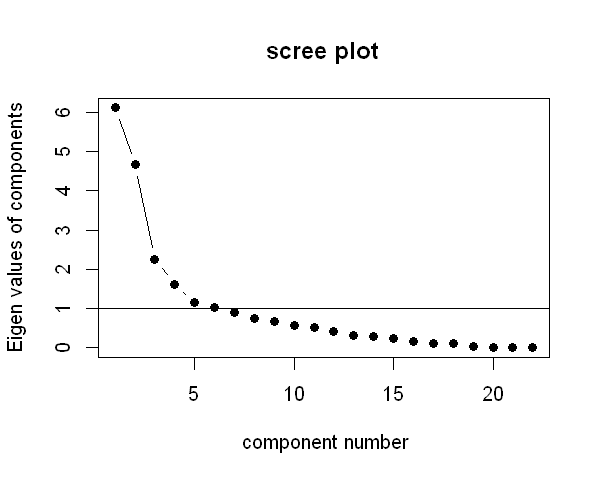

In [39]:
options(repr.plot.width=5, repr.plot.height=4)
# A correlation Matrix is built
corrm<- as.data.frame(cor(cc_numeric))
# There does not seem to be any kind of strong relationships between the services except for AVG_PER_TRX_CA. So it is removed.
cc_numeric$AVG_PER_TRX_CA <- NULL


# Factor analysis is conducted
cc_numeric$PURCHASE_TYPE_Installments <- NULL
cc_numeric$`PURCHASE_TYPE_Cash Advance` <- NULL
cc_numeric$`PURCHASE_TYPE_One-off` <- NULL
corrm <- cor(cc_numeric)
# Relationship of dummy variables are removed as they are important for deriving cluster insigts

scree(corrm, factors=F, pc=T, main="scree plot", hline=NULL, add=FALSE)

eigen_values <- mutate(data.frame(eigen(corrm)$values)
                       ,cum_sum_eigen=cumsum(eigen.corrm..values)
                       , pct_var=eigen.corrm..values/sum(eigen.corrm..values)
                       , cum_pct_var=cum_sum_eigen/sum(eigen.corrm..values))

# Eigen value is less than 1 when it is at 7, so 7 factors are taken into consideration

FA <- NULL
FA<-fa(r=corrm,7, rotate="varimax", fm="ml")
FA_SORT<-fa.sort(FA)
Loadings<-data.frame(FA_SORT$loadings[1:ncol(cc_numeric),])


In [40]:
Loadings # we look at the loadings of the variables for each factor.

,ML1,ML2,ML3,ML7,ML4,ML5,ML6
ONEOFF_PURCHASES,0.97482979,0.009792477,0.090320439,-0.003653220,-0.004057602,-0.119746573,0.034634865
AVG_PURCHASES,0.91580225,0.020605346,0.279959333,0.001402499,-0.027506379,0.277158496,-0.012469207
PURCHASES,0.91384733,0.019097817,0.279212786,0.003067851,-0.027550801,0.282356525,0.044291896
ONEOFF_PURCHASES_FREQUENCY,0.63623346,-0.035227406,0.335420920,-0.025704026,0.017776136,-0.241440772,0.050241878
PURCHASES_TRX,0.61704973,-0.008125809,0.510404522,0.045638577,-0.016478710,0.241577720,0.085667074
PAYMENTS,0.50440086,0.494834263,0.042863140,-0.025840772,0.086879003,0.186302813,0.139310881
AVG_PER_TRX_PUR,0.39247820,-0.026642751,-0.105649230,-0.093210006,-0.108727978,0.036314507,-0.047253502
CASH_ADVANCE,-0.06936758,0.944854780,-0.109702402,0.171052596,0.230595916,-0.036748479,-0.040739308
AVG_CASH_ADVANCE,-0.06905435,0.931028261,-0.110693779,0.160223179,0.227859795,-0.035372476,-0.148757920
CREDIT_LIMIT,0.34581696,0.360841163,0.077356869,0.077730330,0.015904498,0.068304460,0.148925706


From the factor loadings, the final variables taken for analysis are as follows

In [41]:
vars <- c("ONEOFF_PURCHASES","PURCHASES","PAYMENTS","CASH_ADVANCE","PURCHASES_FREQUENCY","LIMIT_USAGE","BALANCE","CASH_ADVANCE_FREQUENCY",
          "INSTALLMENTS_PURCHASES","TENURE")

### Clustering

The clustering method used here is K-Means clustering, where K refers to the number of clusters. In this method, we decide the ideal number of clusters based on the Silhouette Average Widths for various K values and the one with the higher value and highest number of general and variation in clusters will be considered to perform inferences.

First, the input data is selected and scaled

In [42]:
inputdata_final <- cc[,vars,with = F]
inputdata_final <- scale(inputdata_final)

We create empty lists and loop for k values from 3 to 12

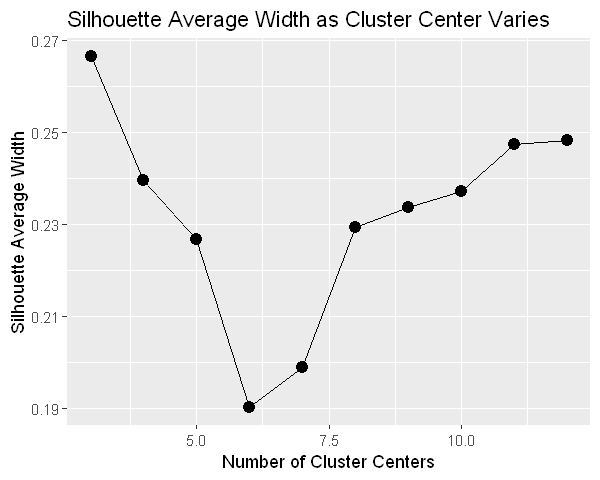

In [43]:
km.out <- list()
sil.out <- list()
x <- vector()
y <- vector()

minClust <- 3 
maxClust <- 12

for (centr in minClust:maxClust) {
  i <- centr-(minClust-1)
  set.seed(11)            
  km.out[i] <- list(kmeans(inputdata_final, centers = centr))
  sil.out[i] <- list(silhouette(km.out[[i]][[1]], dist(inputdata_final)))
  # Used for plotting silhouette average widths
  x[i] = centr  # value of k
  y[i] = summary(sil.out[[i]])[[4]]  # Silhouette average width
}


ggplot(data = data.frame(x, y), aes(x, y)) + 
  geom_point(size=3) + 
  geom_line() +
  xlab("Number of Cluster Centers") +
  ylab("Silhouette Average Width") +
  ggtitle("Silhouette Average Width as Cluster Center Varies")


As per the graph cluster 3 seems to be the best one, but since there is no drastic difference between 3 and 5 to 4 they are also considered. (The others are not considered as this would create small clusters)

Profiling is done for these clusters

In [44]:
cluster_three <- kmeans(inputdata_final,3)
cluster_four <- kmeans(inputdata_final,4)
cluster_five <- kmeans(inputdata_final,5)

cc_seg<-cbind(cc,clust_3=cluster_three$cluster,clust_4=cluster_four$cluster,clust_5=cluster_five$cluster)

cc_seg$clust_3 <- as.factor(cc_seg$clust_3)
cc_seg$clust_4 <- as.factor(cc_seg$clust_4)
cc_seg$clust_5 <- as.factor(cc_seg$clust_5)

profiles <- tabular(1+ONEOFF_PURCHASES+PURCHASES+PAYMENTS+CASH_ADVANCE+PURCHASES_FREQUENCY+LIMIT_USAGE+BALANCE+CASH_ADVANCE_FREQUENCY+
                    INSTALLMENTS_PURCHASES+TENURE+PURCHASE_TYPE_Installments+`PURCHASE_TYPE_Cash Advance`+
                      `PURCHASE_TYPE_One-off`~mean+(mean*clust_3)+(mean*clust_4)+(mean*clust_5),data = cc_seg)

profiles1 <- as.data.table(as.matrix(profiles))
profiles1 <- as.data.table(profiles1)

profiles<-tabular(1~length+(length*clust_3)+(length*clust_4)+(length*clust_5),data=cc_seg)
profiles2<-as.matrix(profiles)
profiles2<-data.table(profiles2)

In [45]:
profiles1

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14
,,mean,,,mean,,,,mean,,,,
,,clust_3,,,clust_4,,,,clust_5,,,,
,mean,1,2,3,1,2,3,4,1,2,3,4,5
All,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
ONEOFF_PURCHASES,547.8877,255.2656,194.1423,826.46448,407.3486,190.6924,298.0175,3273.61204,223.33889,630.32161,161.4743,316.2920,3799.41722
PURCHASES,957.5576,431.4158,306.1946,1468.68554,814.5010,322.5741,508.3464,5210.43162,338.16226,1366.78869,241.8462,534.7286,5850.42060
PAYMENTS,1700.3110,717.8336,1985.2603,1651.29019,1046.0400,1035.1411,4008.6379,5215.12816,870.82158,1428.31635,963.1107,4020.8379,5954.70310
CASH_ADVANCE,950.6255,1218.5328,2082.8645,155.24978,107.2784,882.0914,4949.1129,564.22094,273.69670,152.96180,916.9350,5003.0542,632.55772
PURCHASES_FREQUENCY,0.4960,0.4393,0.2058,0.69817,0.6404,0.2784,0.3024,0.92148,0.31733,0.90914,0.2305,0.3115,0.91784
LIMIT_USAGE,0.3948,0.3593,0.6647,0.21945,0.1080,0.7008,0.6064,0.34872,0.09924,0.23540,0.7532,0.6059,0.35993


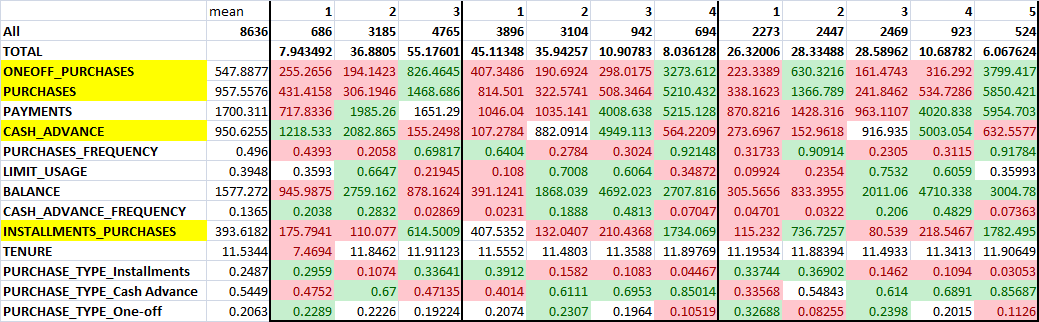

For a more detailed and visually appealing look a the data (i.e the image provided above), look at the **Segment Profiles.xlsx** file provided along with this. The ideal solution for this is the 5 segment as this does not dilute the segments. We will use this to make the interpretation.

## Segments Interpretation

### The following are the identified segments

**Low Spenders** - This first segment contains the customers who spend significantly less than the overall average on everything

**Low Value Active Spenders** - The customers in this segment spend more when buying through installments and one-off purchases, but not much on cash advance eventhought that is their prefered purchase type. 

**Low spend Limit Maintainers** - These customers spend below than average value on all purchase types except for cash advance (which is on par with overall average). They have higher limit usage and balance. These type might be more likely to default.

**Prudent Credit Users** - This segment of customers has people who use Credit card with prudence. They have a very high balance but at the same time make enough payments. They prefer cash advance too.

**High Value "Idel" Customers** - They are high value spenders in almost all purchase type, except for cash advance, and have high preference for that too. They are frequent in purchasing. Though they have high balance, the limit usage is less, making them a great segment.

### Strategic Insights/ Actions to be Taken

- From the segments created, more well targeted efforts can be done by the company.
- In comparisions made between the 3rd, 4th and 5th groups on the Limit Usage, it is seen that the 3rd and 4th group is inching close to their credit limit. There is a greater risk for default in this case, so efforts to make quick re-payment with special interest discounts for these customers who pay early.
- Cash advance happense to be a favourite for the 3rd, 4th and 5th segments but since the average there is less, so a special cash back for every cash advance purchases above 1000 can be used to promote higher usage.
- Reward points for customers who keep credit limit below 0.4 and have an average transaction value of 900 can be given. These reward points can be used to avail discounts at popular stores.
- The first segment does not spend a lot and must be encouraged to. They can be given interest free credit upto USD 100 for upto 5 transactions. This will prompt them to use it for more high value purchases.
- The second segment can be prompted to spend more by giving cash backs on installment purchases and cash advance purchases.